In [ ]:
import torchvision
import torch

In [ ]:
from torch.utils.data import Sampler
from torchvision.transforms import RandomResizedCrop
import torchvision
from torchvision.transforms import RandomHorizontalFlip
from torchvision.transforms import ColorJitter

In [ ]:
rrc = RandomResizedCrop((224, 224), scale=(1, 1), ratio=(1, 1), interpolation=torchvision.transforms.InterpolationMode.BILINEAR)
rhf = RandomHorizontalFlip(p=0.5)
cj = ColorJitter(brightness=0.3, contrast=0.3, saturation=0, hue=0) 
tt = torchvision.transforms.ToTensor()
n = torchvision.transforms.Normalize(mean=0.5, std=0.5)
re = torchvision.transforms.RandomErasing(p=0.5, scale=(0.02, 0.3), ratio=(0.3, 3.3), value=0) 

In [ ]:
tc = torchvision.transforms.Compose([
  rrc,
  rhf,
  cj,
  tt,
  n,
  re
])

In [ ]:
train_ds = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=tc)
nb_classes = 10


Extracting ./cifar-10-python.tar.gz to .


In [ ]:
# import numpy as np
# print(np.array(train_ds[7][0]).shape)
# re(n(tt((cj(rhf(rrc(train_ds[2][0])))))))

In [ ]:
print(train_ds[0])

(tensor([[[-0.1137, -0.1137, -0.1137,  ..., -0.5765, -0.5765, -0.5765],
         [-0.1137, -0.1137, -0.1137,  ..., -0.5765, -0.5765, -0.5765],
         [-0.1137, -0.1137, -0.1137,  ..., -0.5765, -0.5765, -0.5765],
         ...,
         [-0.2471, -0.2471, -0.2471,  ...,  0.0275,  0.0275,  0.0275],
         [-0.2471, -0.2471, -0.2471,  ...,  0.0275,  0.0275,  0.0275],
         [-0.2471, -0.2471, -0.2471,  ...,  0.0275,  0.0275,  0.0275]],

        [[-0.2392, -0.2392, -0.2392,  ..., -0.5608, -0.5608, -0.5608],
         [-0.2392, -0.2392, -0.2392,  ..., -0.5608, -0.5608, -0.5608],
         [-0.2392, -0.2392, -0.2392,  ..., -0.5608, -0.5608, -0.5608],
         ...,
         [-0.4039, -0.4039, -0.4039,  ..., -0.1451, -0.1451, -0.1451],
         [-0.4039, -0.4039, -0.4039,  ..., -0.1451, -0.1451, -0.1451],
         [-0.4039, -0.4039, -0.4039,  ..., -0.1451, -0.1451, -0.1451]],

        [[-0.3490, -0.3490, -0.3490,  ..., -0.5608, -0.5608, -0.5608],
         [-0.3490, -0.3490, -0.3490,  ..., -

In [ ]:
class RASampler(Sampler):
  def __init__(self, dataset, num_replicas, shuffle=True):
    self.dataset = dataset
    self.num_replicas = num_replicas
    self.shuffle = shuffle

  def __iter__(self):
    indices = list(range(0, len(self.dataset)))
    
    #random.shuffle(indices)
    return iter([idx for idx in indices for i in range(3)])
  def __len__(self):
    return self.num_replicas * len(self.dataset)

rasampler = RASampler(train_ds, 3, True)



In [ ]:
it = iter(rasampler)

In [ ]:
next(it)

0

In [ ]:
len(train_ds)

50000

In [ ]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=1, sampler=rasampler)

In [ ]:
len(train_dl)

150000

In [ ]:
rrc = RandomResizedCrop((384, 384), scale=(1, 1), ratio=(1, 1), interpolation=torchvision.transforms.InterpolationMode.BILINEAR)
rhf = RandomHorizontalFlip(p=0.5)
cj = ColorJitter(brightness=0.3, contrast=0.3, saturation=0, hue=0) 
tt = torchvision.transforms.ToTensor()
n = torchvision.transforms.Normalize(mean=0.5, std=0.5)
re = torchvision.transforms.RandomErasing(p=0.5, scale=(0.02, 0.3), ratio=(0.3, 3.3), value=0) 
tc_fine = torchvision.transforms.Compose([
  rrc,
  rhf,
  cj,
  tt,
  n,
  re
])
finetune_train_ds = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=tc_fine)
nb_classes = 10

Files already downloaded and verified


In [ ]:
!pip install timm

     |████████████████████████████████| 348kB 13.1MB/s 


In [ ]:
from torch import nn
import torch.nn.functional as F
from timm.models.layers import trunc_normal_
D = 512
h = 8
B = 16
d = D // h
patch_size = 16
#N = (224 // patch_size)*(224//patch_size) + 2
num_classes = 10

class MSA(nn.Module):
  def __init__(self):
    super(MSA, self).__init__()
    self.QKV_embed = nn.Linear(D, 3*D)
    self.proj = nn.Linear(D, D)
  
  def forward(self, X):
    #X : B N D
    B = X.size(0)
    QKV = self.QKV_embed(X).reshape(B, -1, 3, h, d).permute(2, 0, 3, 1, 4) # B N 3D -> B 3D N -> B 3 D N
    Q, K, V = QKV[0], QKV[1], QKV[2]

    X = torch.softmax(Q @ K.transpose(-1, -2) * d**(-1/2), dim=-1) @ V # B h N d
    X = X.permute(0, 2, 1, 3).reshape(B, -1, D)
    X = self.proj(X)
    return X

class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.ff0 = nn.Linear(D, 4*D)
    self.ff1 = nn.Linear(4*D, D)
  
  def forward(self, X):
    #X : B N D
    X = F.gelu(self.ff0(X))
    X = self.ff1(X)
    return X

class Block(nn.Module):
  def __init__(self, drop_path_rate):
    super(Block, self).__init__()
    self.drop_path_rate = drop_path_rate
    self.norm1 = nn.LayerNorm(D, eps=1e-6)
    self.norm2 = nn.LayerNorm(D, eps=1e-6)
    self.MSA = MSA()
    self.MLP = MLP()
  def drop_path(self, x, drop_path_rate):
    if drop_path_rate == 0.:
      return x

    rand = torch.rand((x.shape[0],) + (1,)*(x.ndim-1))
    rand = torch.floor((1-drop_path_rate) + rand)
    return x / (1-drop_path_rate) * rand
  

  def forward(self, X):
    X = X + self.drop_path(self.MSA(self.norm1(X)), self.drop_path_rate)
    X = X + self.drop_path(self.MLP(self.norm2(X)), self.drop_path_rate)
    return X

class DeiT(nn.Module):
  def __init__(self):
    super(DeiT, self).__init__()
    # D = 512
    # h = 8
    # d = D // h # 64
    patch_size = 16
    #N = (224 // patch_size)**2 + 2 # distill ver.
    self.patch_embed = nn.Conv2d(3, D, kernel_size=16, stride=16)
    self.pos_enc = nn.Parameter(torch.zeros(1, (224//16) * (224//16) + 2, D)) ###
    self.cls_patch = nn.Parameter(torch.zeros(1, 1, D))
    self.dist_patch = nn.Parameter(torch.zeros(1, 1, D))


    self.drop_depth = 0.1
    drop_depth_p = torch.linspace(0, self.drop_depth, 10)
    self.blocks = nn.Sequential(*[
        Block(drop_depth_p[i])
      for i in range(10)])
    
    self.norm_patch = nn.LayerNorm(D)
    self.norm = nn.LayerNorm(D)
    self.cls_head = nn.Linear(D, num_classes)
    self.dist_head = nn.Linear(D, num_classes)
    self.init_weights()


    high_res = True
    if high_res:
      self.pos_enc = self.resize_pos_enc(self.pos_enc)

  def init_weights(self):
    trunc_normal_(self.pos_enc, std=.02)
    trunc_normal_(self.cls_patch, std=.02)
    self.apply(self.init_weights_func)
  
  def init_weights_func(self, m):
    
    if isinstance(m, nn.Linear):
      trunc_normal_(m.weight, std=.02)
      torch.nn.init.zeros_(m.bias)
      
    # elif isinstance(m, nn.Conv2d):
    #   return
      
    elif isinstance(m, nn.LayerNorm):
      torch.nn.init.ones_(m.weight)
      torch.nn.init.zeros_(m.bias)


  def forward(self, X):
    #So Low Efficiency... Maybe I should print/lookahead official code 
    # X: H, W, 3 (224 * 224)
    B = X.size(0)
    D = 512
    h = 8
    d = D // h # 64
    patch_size = 16
     # no distill ver.
    #N = (224 // patch_size)*(224//patch_size) + 1

    ### get patches
    H = self.patch_embed(X) # B D H W
    H = H.flatten(2).transpose(1, 2)
    H = self.norm_patch(H)


    ### add cls_patch
    H = torch.cat((self.cls_patch.expand(B, -1, -1),
                   self.dist_patch.expand(B, -1, -1),
                   H), dim=1)
    
    ### positional encoding
    H = H + self.pos_enc    

    ### MSA, FF(MLP)
    H = self.blocks(H)


    # H_q = Q.transpose(0, 2, 1).reshape(-1, h, d, N).transpose(0, 1, 3, 2) # N h N d


    # MASK = torch.ones(N, N)
    # MASK[:N-1, N-1] *= -1e9
    # Attention = torch.matmul(torch.softmax(torch.matmul(H_q, H_k) * MASK / torch.sqrt(d)), H_v)

    # _H = np.zeros(X.size(0), N, D)
    # _H = Attention.transpose(0, 2, 1, 3).view(-1, N, D) # : N H d -> : N D
    
      #norm
    H = self.norm(H)
    ### class embedding
    
    ### get classification result
    cls_patch = H[:, 0, :]
    dist_patch = H[:, 1, :]
    H_cls = self.cls_head(cls_patch)
    H_dist = self.dist_head(dist_patch)
    return H_cls, H_dist
  
  def resize_pos_enc(self, pos_enc):
    #14*14 -> 24*24
    pos_enc_token = pos_enc[:, :2, :]
    pos_enc_grid = pos_enc[:, 2:, :]
    n = int(pos_enc_grid.size(1) ** 0.5)
    n_ = 24
    D = pos_enc_grid.size(2)
    _pos_enc_grid = pos_enc_grid.reshape(-1, n, n, D).permute(0, 3, 1, 2)
    _pos_enc_grid = F.interpolate(_pos_enc_grid, size=(n_, n_), mode='bicubic', align_corners=False)
    pos_enc_grid = _pos_enc_grid.permute(0, 2, 3, 1).flatten(1, 2)
    pos_enc = torch.cat((pos_enc_token, pos_enc_grid), dim=1)
    print(pos_enc.shape)
    return nn.Parameter(pos_enc)
    

In [ ]:
def get_loss(H_cls, Y):
  loss = F.cross_entropy(H_cls, Y)
  return loss


# teacher_model = create_model(
#   'regnety_160',
#   pretrained=True,
#   num_classes=args.nb_classes,
#   global_pool='avg',
# )
def get_loss_dist(X, H_cls, H_dist, Y):
  #teacher_Y = teacher_model(X)
  loss = 0.5*F.cross_entropy(H_cls, Y) #+ 0.5*...
  return loss

In [ ]:
import numpy as np
import argparse
parser = argparse.ArgumentParser('DeiT training and evaluation script', add_help=False)

# Learning rate schedule parameters
parser.add_argument('--sched', default='cosine', type=str, metavar='SCHEDULER',
                    help='LR scheduler (default: "cosine"')
parser.add_argument('--epochs', default=300, type=int)
parser.add_argument('--min-lr', type=float, default=1e-5, metavar='LR',
                    help='lower lr bound for cyclic schedulers that hit 0 (1e-5)')
parser.add_argument('--decay-rate', '--dr', type=float, default=0.1, metavar='RATE',
                    help='LR decay rate (default: 0.1)')
parser.add_argument('--warmup-lr', type=float, default=1e-6, metavar='LR',
                    help='warmup learning rate (default: 1e-6)')
parser.add_argument('--warmup-epochs', type=int, default=5, metavar='N',
                    help='epochs to warmup LR, if scheduler supports')

#None
parser.add_argument('--lr-noise', type=float, nargs='+', default=None, metavar='pct, pct',
                    help='learning rate noise on/off epoch percentages')
parser.add_argument('--lr-noise-pct', type=float, default=0.67, metavar='PERCENT',
                    help='learning rate noise limit percent (default: 0.67)')
parser.add_argument('--lr-noise-std', type=float, default=1.0, metavar='STDDEV',
                    help='learning rate noise std-dev (default: 1.0)')

parser.add_argument('--lr', type=float, default=5e-4, metavar='LR',
                    help='learning rate (default: 5e-4)')


parser.add_argument('--cooldown-epochs', type=int, default=10, metavar='N',
                    help='epochs to cooldown LR at min_lr, after cyclic schedule ends')

args = parser.parse_args(args=[])

In [ ]:
model = DeiT()
train_dl = DataLoader(finetune_train_ds, batch_size=B, sampler=rasampler)
opt = torch.optim.AdamW(model.parameters(), 0.0005*(B/512), weight_decay = 0.05)

from timm.scheduler import create_scheduler
scheduler = create_scheduler(args, opt)[0] # lr_scheduler, num_epochs

for epoch_idx in range(5):
  for (batch_idx, (X, Y)) in enumerate(train_dl):
    Y_pred_cls, Y_pred_dist = model(X)
    loss = get_loss(Y_pred_cls, Y)

    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())
    break
  scheduler.step(epoch_idx)

torch.Size([1, 578, 512])
2.4942688941955566
2.4910099506378174
2.3026230335235596
2.105471611022949
1.6161545515060425


In [ ]:
for epoch_idx in range(5, 10):
  for (batch_idx, (X, Y)) in enumerate(train_dl):
    Y_pred = model(X)
    loss = get_loss(Y_pred, Y)

    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())
    break
  scheduler.step(epoch_idx)

NameError: ignored

In [ ]:
#eval
def acc1(Y_pred, Y):
  print(Y_pred.argmax(dim=-1), Y)
  return (Y_pred.argmax(dim=-1) == Y).sum()

def acc5(Y_pred, Y):
  _, Y_pred_topk = torch.topk(Y_pred, 5, dim=-1)
  return (Y_pred_topk == Y[:, None].expand_as(Y_pred_topk)).sum()



for (batch_idx, (X, Y)) in enumerate(train_dl):
  with torch.no_grad():

    Y_pred = model(X)
    loss = get_loss(Y_pred, Y)

    print(loss.item())
    print(acc1(Y_pred, Y) / Y.size(0))
    print(acc5(Y_pred, Y) / Y.size(0))
    break

3.149411916732788
tensor([ 1,  1, 65,  9,  9,  9,  9,  9,  9,  1,  1,  1,  1,  1,  1,  1]) tensor([6, 6, 6, 9, 9, 9, 9, 9, 9, 4, 4, 4, 1, 1, 1, 1])
tensor(0.6250)
tensor(1.)


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


33 forest
tensor([4])
tensor([[4, 9, 6, 1, 2]])
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip

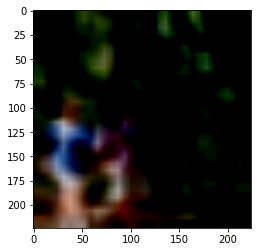

In [ ]:
rs = torchvision.transforms.Resize((224, 224))
tt = torchvision.transforms.ToTensor()
n = torchvision.transforms.Normalize(mean=0.5, std=0.5)
tc_val = torchvision.transforms.Compose([
  rs,
  tt,
  n,
])
valid_ds = torchvision.datasets.CIFAR10('.', train=False, download=True, transform=tc_val)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 197, 512])
6 frog
tensor([6])
tensor([[6, 4, 0, 3, 7]])
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


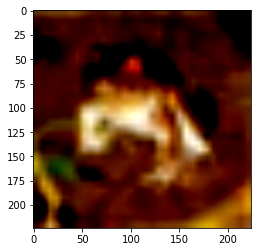

In [ ]:
img = train_ds[0][0]
y = train_ds[0][1]
#rc = torchvision.transforms.Resize()


import matplotlib.pyplot as plt
plt.imshow(img.permute(1, 2, 0).numpy())

with torch.no_grad():
  y_pred = model(img[None, :, :, :])
  print(y, train_ds.classes[y])
  print(y_pred.argmax(dim=-1))
  print(torch.topk(y_pred, 5, dim=-1)[1])
  print(train_ds.classes)


In [ ]:
from torch import nn
import torch.nn.functional as F

In [ ]:
import torch
x = torch.zeros(3, 5, 2, 4)
shape = (x.shape[0],) + (1,) * (x.ndim - 1)
print((x.shape[0],) + (1,) * (x.ndim - 1))
print((1,) + (2,))

(3, 1, 1, 1)
(1, 2)
